In [1]:
import csv
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.autograd import Variable

In [2]:
hdrs = None
data = None
# parse data from song features
with open("data/5000_artist_song_features.csv", "r") as f:
    reader = csv.reader(f)
    all_rows = list(reader)
    hdrs = all_rows[0]
    data = all_rows[1:]

# join artist popularity into data set
artists = {}
hdrs.append('artist_popularity')
with open("data/5000_artist_list.csv", "r", encoding='ISO-8859-1') as f:
    reader = csv.reader(f); next(reader)
    for row in reader:
        artists[row[0]] = {
            "name": row[1],
            "popularity": row[2]
        }
for i in range(len(data)):
    artist_id = data[i][1]
    if artist_id in artists:
        data[i].append(artists[artist_id]["popularity"])

In [3]:
print("Number of data rows: {}".format(len(data)))
data = list(filter(lambda row: len(row) == 21, data))
print("Number of valid data rows: {}".format(len(data)))

data_idx = [
    'duration', 'explicit', 'danceability', 'energy', 'key', 'loudness', 
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo', 'time_signature'#, 'artist_popularity'
]
x_data_idx = list(map(lambda d: hdrs.index(d), data_idx))
y_data_idx = [hdrs.index('popularity')]

# do some parsing and convert data
for i in range(len(data)):
    data[i][4] = str(int(data[i][4] == 'True'))
data = np.array(data)

# retrieve features and predicted values
y_data = data[:, y_data_idx].astype(np.float)
x_data = data[:, x_data_idx].astype(np.float)

Number of data rows: 43797
Number of valid data rows: 40134


In [11]:
N, F = x_data.shape
N_TRAIN = int(N * 0.9)
x_train = Variable(torch.Tensor(x_data[:N_TRAIN]), requires_grad=False)
y_train = Variable(torch.Tensor(y_data[:N_TRAIN]), requires_grad=False)
x_test = Variable(torch.Tensor(x_data[N_TRAIN:]), requires_grad=False)
y_test = Variable(torch.Tensor(y_data[N_TRAIN:]), requires_grad=False)
w_beta = Variable(torch.randn(F, 1), requires_grad=True)
w_alph = Variable(torch.randn(1), requires_grad=True)
optim = torch.optim.Adam([w_beta, w_alph], lr=0.1)

In [12]:
print("Starting on SGD")
N_STEPS = 20000
losses = []
for step in range(N_STEPS):
    pred = x_train.mm(w_beta).add(w_alph.expand(N_TRAIN, 1))
    loss = (pred - y_train).pow(2).sum()
    if (step + 1) % 500 == 0:
        print("Done with step {:05d} out of {:05d}; loss is {}".format(
            step + 1, N_STEPS, loss.data.numpy()[0]
        ))
    losses.append(loss.data.numpy()[0])
    optim.zero_grad()
    loss.backward()
    optim.step()

Starting on SGD
Done with step 00500 out of 10000; loss is 35571236.0
Done with step 01000 out of 10000; loss is 26641210.0
Done with step 01500 out of 10000; loss is 21406586.0
Done with step 02000 out of 10000; loss is 19376376.0
Done with step 02500 out of 10000; loss is 18695422.0
Done with step 03000 out of 10000; loss is 18319282.0
Done with step 03500 out of 10000; loss is 17982340.0
Done with step 04000 out of 10000; loss is 17685528.0
Done with step 04500 out of 10000; loss is 17454952.0
Done with step 05000 out of 10000; loss is 17274680.0
Done with step 05500 out of 10000; loss is 17126396.0
Done with step 06000 out of 10000; loss is 16999732.0
Done with step 06500 out of 10000; loss is 16889226.0
Done with step 07000 out of 10000; loss is 35164499968.0
Done with step 07500 out of 10000; loss is 1486116864.0
Done with step 08000 out of 10000; loss is 19474192.0
Done with step 08500 out of 10000; loss is 16551830.0
Done with step 09000 out of 10000; loss is 16481669.0
Done wi

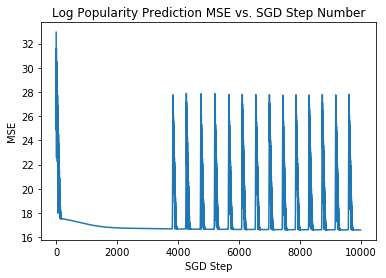

In [20]:
plt.plot(
    list(range(1, len(losses) + 1)),
    list(map(np.log, losses))
)
plt.xlabel("SGD Step")
plt.ylabel("MSE")
plt.title("Log Popularity Prediction MSE vs. SGD Step Number")
plt.show()

In [19]:
np.save('npy/lin_reg_b', w_beta)
np.save('npy/lib_reg_a', w_alph)